In [1]:
!pip install d2l==0.16.1

     |████████████████████████████████| 81kB 3.6MB/s 


In [ ]:
from d2l import torch as d2l
import torch
import random

# 4. Language Models and the Dataset



$$P(x_1, x_2, \ldots, x_T).$$


<br>
<br>
<br>
<br>
<br>
<br>




Language models are of great service even in their limited form. For instance, the phrases “to recognize speech” and “to wreck a nice beach” sound very similar. This can cause ambiguity in speech recognition, which is easily resolved through a language model that rejects the second translation as outlandish. 
Likewise, in a document summarization algorithm
it is worthwhile knowing that "dog bites man" is much more frequent than "man bites dog", or that "I want to eat grandma" is a rather disturbing statement, whereas "I want to eat, grandma" is much more benign.


## Learning a Language Model



$$P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^T P(x_t  \mid  x_1, \ldots, x_{t-1}).$$

For example, 
the probability of a text sequence containing four words would be given as:

$$P(\text{deep}, \text{learning}, \text{is}, \text{fun}) =  P(\text{deep}) P(\text{learning}  \mid  \text{deep}) P(\text{is}  \mid  \text{deep}, \text{learning}) P(\text{fun}  \mid  \text{deep}, \text{learning}, \text{is}).$$




<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


In order to compute the language model, we need to calculate the
probability of words and the conditional probability of a word given
the previous few words.
Such probabilities are essentially
language model parameters.


<br>
<br>
<br>
<br>




$$\hat{P}(\text{learning} \mid \text{deep}) = \frac{n(\text{deep, learning})}{n(\text{deep})},$$

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

$$\begin{aligned}
	\hat{P}(x) & = \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
	\hat{P}(x' \mid x) & = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
	\hat{P}(x'' \mid x,x') & = \frac{n(x, x',x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
\end{aligned}$$


## Markov Models and $n$-grams

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


$$
\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).
\end{aligned}
$$

The probability formulae that involve one, two, and three variables are typically referred to as *unigram*, *bigram*, and *trigram* models, respectively. In the following, we will learn how to design better models.



#Language Statistics

In [ ]:
tokens = d2l.tokenize(d2l.read_time_machine())
# Since each text line is not necessarily a sentence or a paragraph, we
# concatenate all text lines
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

As we can see, the most popular words are actually quite boring to look at.
They are often referred to as *stop words* and thus filtered out.
Nonetheless, they still carry meaning and we will still use them.
Besides, it is quite clear that the word frequency decays rather rapidly. The $10^{\mathrm{th}}$ most frequent word is less than $1/5$ as common as the most popular one. To get a better idea, we plot the figure of the word frequency.


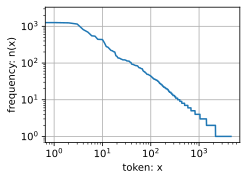

In [ ]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

We are on to something quite fundamental here: the word frequency decays rapidly in a well-defined way.
After dealing with the first few words as exceptions, all the remaining words roughly follow a straight line on a log-log plot. This means that words satisfy *Zipf's law*,
which states that the frequency $n_i$ of the $i^\mathrm{th}$ most frequent word
is:

$$n_i \propto \frac{1}{i^\alpha},$$


which is equivalent to

$$\log n_i = -\alpha \log i + c,$$

where $\alpha$ is the exponent that characterizes the distribution and $c$ is a constant.


In [ ]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

One thing is notable here. Out of the ten most frequent word pairs, nine are composed of both stop words and only one is relevant to the actual book---"the time". Furthermore, let us see whether the trigram frequency behaves in the same manner.


In [ ]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

Last, let us visualize the token frequency among these three models: unigrams, bigrams, and trigrams.


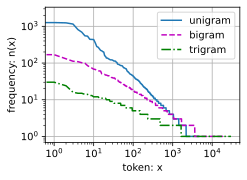

In [ ]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])



## Reading Long Sequence Data


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>




### Random Sampling

In random sampling, each example is a subsequence arbitrarily captured on the original long sequence.
The subsequences from two adjacent random minibatches
during iteration
are not necessarily adjacent on the original sequence.
For language modeling,
the target is to predict the next token based on what tokens we have seen so far, hence the labels are the original sequence, shifted by one token.

The following code randomly generates a minibatch from the data each time.
Here, the argument `batch_size` specifies the number of subsequence examples in each minibatch
and `num_steps` is the predefined number of time steps
in each subsequence.


In [ ]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

Let us manually generate a sequence from 0 to 34.
We assume that
the batch size and numbers of time steps are 2 and 5,
respectively.
This means that we can generate $\lfloor (35 - 1) / 5 \rfloor= 6$ feature-label subsequence pairs. With a minibatch size of 2, we only get 3 minibatches.


In [ ]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 0,  1,  2,  3,  4],
        [25, 26, 27, 28, 29]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [26, 27, 28, 29, 30]])
X:  tensor([[10, 11, 12, 13, 14],
        [ 5,  6,  7,  8,  9]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [ 6,  7,  8,  9, 10]])
X:  tensor([[15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]]) 
Y: tensor([[16, 17, 18, 19, 20],
        [21, 22, 23, 24, 25]])


### Sequential Partitioning

In addition to random sampling of the original sequence, we can also ensure that 
the subsequences from two adjacent minibatches
during iteration
are adjacent on the original sequence.
This strategy preserves the order of split subsequences when iterating over minibatches, hence is called sequential partitioning.


In [ ]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

Using the same settings,
let us print features `X` and labels `Y` for each minibatch of subsequences read by sequential partitioning.
Note that
the subsequences from two adjacent minibatches
during iteration
are indeed adjacent on the original sequence.


In [ ]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


Now we wrap the above two sampling functions to a class so that we can use it as a data iterator later.


In [ ]:
class SeqDataLoader:  #@save
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

Last, we define a function `load_data_time_machine` that returns both the data iterator and the vocabulary, so we can use it similarly as other other functions with the `load_data` prefix, such as `d2l.load_data_fashion_mnist`.


In [ ]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab